In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import Counter
from typing import List, Tuple
import time
import timeit
import pandas as pd
import pyarrow as pa
import numpy as np
import scipy.stats as ss
import hashlib 
import uuid
import math
from multiprocessing import Pool, Process, JoinableQueue
from multiprocessing.pool import ThreadPool
from functools import partial

from tqdm import tqdm
tqdm.pandas()

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter


class CodeTimer:
    def __init__(self, name=None):
        self.name = " '" + name + "'" if name else ""

    def __enter__(self):
        self.start = timeit.default_timer()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (timeit.default_timer() - self.start) * 1000.0
        print("Code block" + self.name + " took: " + str(self.took) + " ms")

In [3]:
from common_utils import Haversine

## Construct Synthetic DataFrame

In [4]:
SIZE = 100_000 # 100_000_000

In [5]:
get_color = {0: "red", 
             1: "blue", 
             2: "yellow", 
             3: "black", 
             4: "green", 
             5: "brown", 
             6: "white"}

In [6]:
## generate a random normal distribution of latitude values: constructing a CDF for latitude coord in Degrees
VAR = 3
x_lat = np.arange(-90., 90., 0.1)
xU, xL = x_lat + 0.5, x_lat - 0.5 
prob = ss.norm.cdf(xU, scale = VAR) - ss.norm.cdf(xL, scale = VAR)
prob_lat = prob / prob.sum() # normalize the probabilities so their sum is 1
# nums = np.random.choice(x, size = SIZE, p = prob)

## generate a random normal distribution of longitude values: constructing a CDF for longitude coord in Degrees
x_lng = np.arange(-180., 180., 0.1)
xU, xL = x_lng + 0.5, x_lng - 0.5 
prob = ss.norm.cdf(xU, scale = VAR) - ss.norm.cdf(xL, scale = VAR)
prob_lng = prob / prob.sum() # normalize the probabilities so their sum is 1
# nums = np.random.choice(x, size = SIZE, p = prob)

In [7]:
## generate floats of `lat` with proba from normal distribution
## generate floats of `lng` with proba from normal distribution
## generate colors with proba from random distribution

df = pd.DataFrame({'color': [get_color.get(np.random.randint(0,7),0) for i in range(SIZE)],
                   'lat'  : np.random.choice(x_lat, size = SIZE, p = prob_lat),
                   'lng'  : np.random.choice(x_lng, size = SIZE, p = prob_lng)
                  })

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   color   100000 non-null  object 
 1   lat     100000 non-null  float64
 2   lng     100000 non-null  float64
dtypes: float64(2), object(1)
memory usage: 7.4 MB


In [9]:
df.sample(n=100).head(15)

,color,lat,lng
39666,brown,-1.5,3.5
4502,brown,1.5,-3.0
89554,white,2.7,-1.8
42131,green,2.6,4.2
23599,yellow,0.5,-0.2
64942,brown,-2.2,0.2
13513,white,3.0,-0.5
52199,yellow,-2.7,-1.8
19276,blue,2.8,1.7
51252,brown,-2.5,-3.2


## Instantiate child class from Haversine object

In [8]:
hh = Haversine(df)

In [9]:
df["XYZ"] = df[['lat', 'lng']].progress_apply(lambda x: hh.geo_to_xyz(x.lat, x.lng), axis=1)

100%|██████████| 100000/100000 [00:00<00:00, 143136.68it/s]


In [10]:
df = df.assign(**dict(zip('xyz', df.XYZ.str)))
# df.drop(columns=["XYZ"], inplace=True)

In [11]:
df.head()

,color,lat,lng,XYZ,x,y,z
0,green,-1.0,0.5,"(0.9998096240198643, 0.008725206404570553, -0....",0.999810,0.008725,-0.017452
1,blue,-1.2,3.4,"(0.9980208974334431, 0.05929336670800773, -0.0...",0.998021,0.059293,-0.020942
2,white,2.1,1.1,"(0.9991442296691928, 0.01918454927776069, 0.03...",0.999144,0.019185,0.036644
3,yellow,0.5,-0.5,"(0.9999238475781949, -0.008726203218819832, 0....",0.999924,-0.008726,0.008727
4,green,0.6,-2.8,"(0.9987513721671856, -0.048847091331916406, 0....",0.998751,-0.048847,0.010472


In [14]:
_ = hh.get_df_w_max_dist()

Cannot find an Agg DataFrame with Max Distance. Start Calc...


In [15]:
hh.df_w_max_dist.head()

,color,dist,centroid
0,black,0.364580,"(0.005414810746512898, 0.011473633993777758)"
1,blue,0.312006,"(-0.014082706438270318, -0.012247135109365977)"
2,brown,0.370412,"(0.022725683821710536, -0.0026543971693111603)"
3,green,0.375664,"(-0.0020065919808356773, -0.04872833891385989)"
4,red,0.375159,"(0.023565560065253274, 0.022206200892565392)"


In [16]:
hh.get_centroid()

No Need to Calc an Agg DataFrame. Already pre-calc


(-0.00919307988911998, 0.05797678084480104)

## Convex Hull

In [12]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

from matplotlib import pyplot as plt
from matplotlib import cm

from matplotlib.animation import FuncAnimation, PillowWriter 

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from scipy.interpolate import griddata

from pylab import rcParams
import seaborn as sns


# rcParams['figure.figsize'] = 10, 6

sns.set(style="whitegrid",
        rc={'figure.figsize':(10,7), 
            'axes.axisbelow': True,
            'axes.edgecolor': '.8',
            'axes.facecolor': 'white',
            'axes.grid': False}
       )

sns.set(style="whitegrid", color_codes=True)
sns.despine()

<Figure size 1000x700 with 0 Axes>

In [13]:
# N = 16_000_000

# Find a convex hull in O(N log N)
points = np.array(df.XYZ.values.tolist())   # N random points in 3-D

# Returned 420 points in testing
hull = ConvexHull(points)

# Extract the points forming the hull
hullpoints = points[hull.vertices,:]

# Naive way of finding the best pair in O(H^2) time if H is number of points on
# hull
hdist = cdist(hullpoints, hullpoints, metric='euclidean')

# Get the farthest apart points
bestpair = np.unravel_index(hdist.argmax(), hdist.shape)

#Print them
print([hullpoints[bestpair[0]],hullpoints[bestpair[1]]])

[array([ 0.97661873, -0.21472355, -0.01047178]), array([0.96962238, 0.24355231, 0.02268733])]


In [21]:
hdist.shape, hullpoints.shape, bestpair

((19663, 19663), (19663, 3), (19217, 19608))

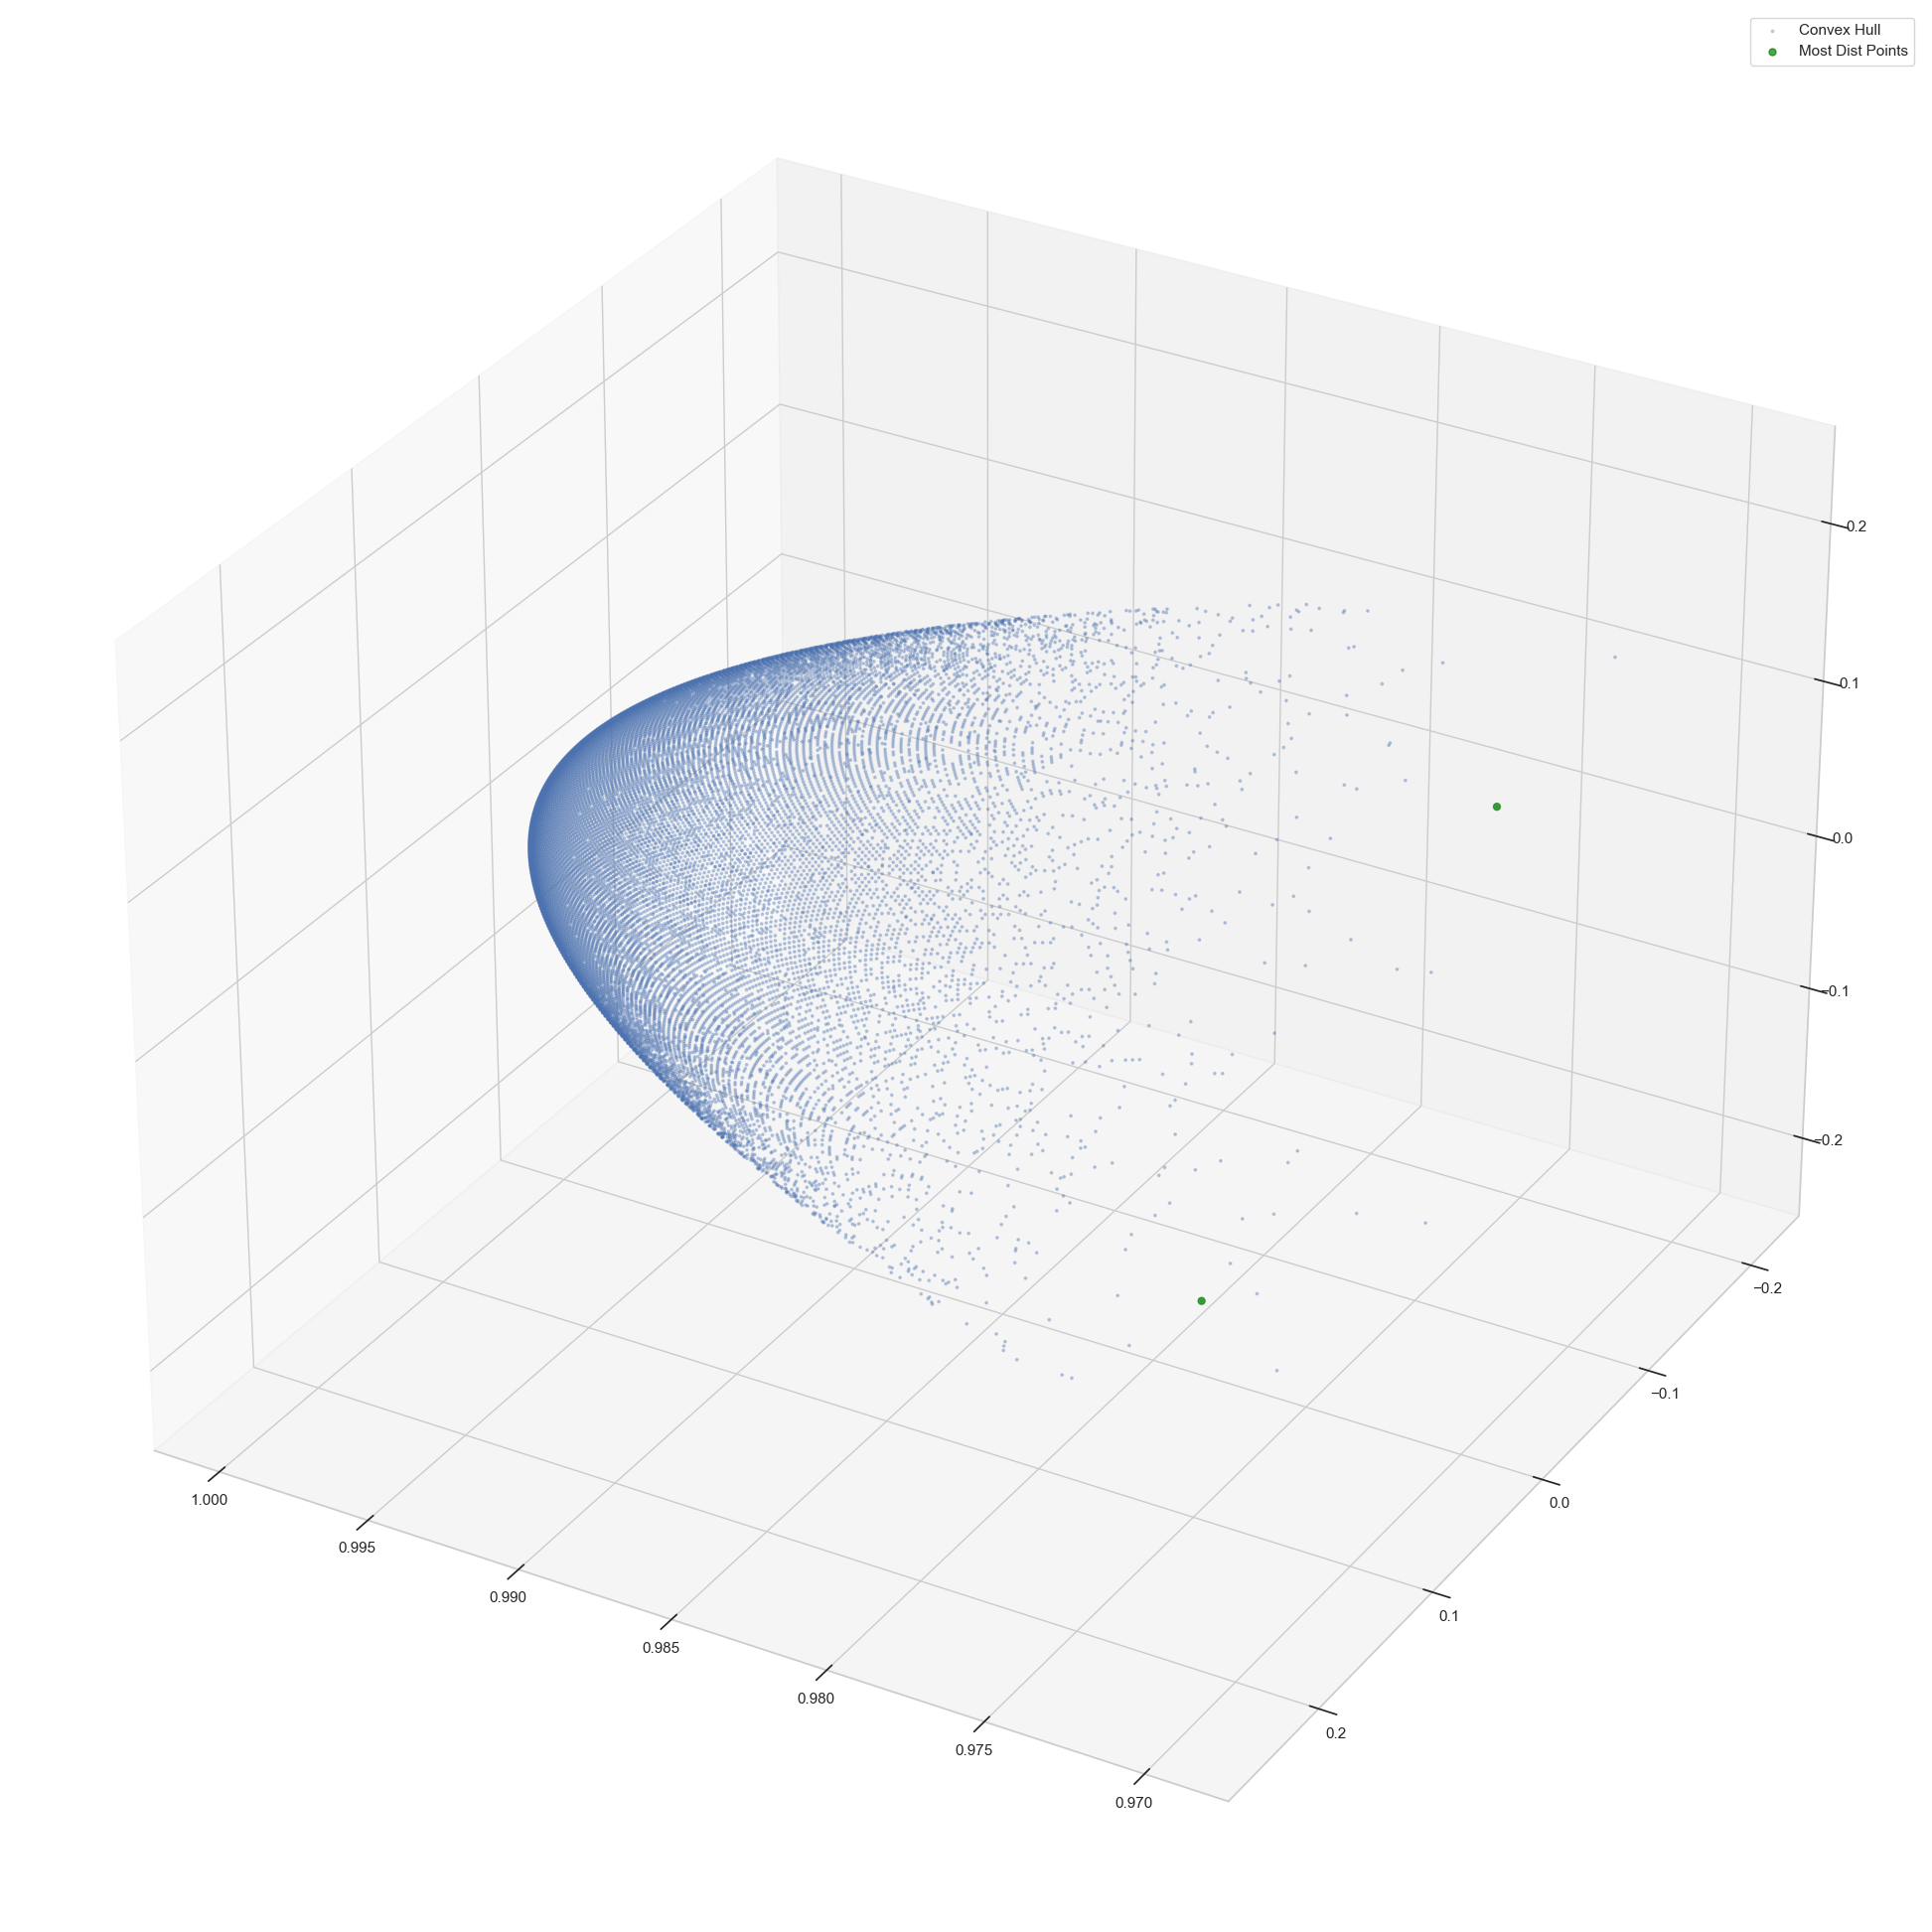

In [28]:
# Get our color map
cm = plt.cm.get_cmap('RdYlBu') #YlOrRd RdYlBu

# Create plot
# fig, axes = plt.subplots(1, 2, figsize=(25, 10))

fig = plt.figure(figsize=(35, 25))
axes = fig.add_subplot(1, 1, 1, projection='3d')

x, y, z  = hullpoints[:, 0], hullpoints[:, 1], hullpoints[:, 2] 
best_p = np.array([hullpoints[bestpair[0]], hullpoints[bestpair[1]]])


# sc = axes.scatter(df.x, 
#                   df.y,
#                   df.z,
#                   label="All Geo Points",
#                   alpha=0.1, 
#                   s=1, 
#                   cmap=df.color) 

sc = axes.scatter(x, 
                  y,
                  z,
                  label="Convex Hull",
                  alpha=0.3, 
                  s=3, 
                  cmap='blue')  
   
    
sc = axes.scatter(best_p[:,0],
                  best_p[:,1],
                  best_p[:,2],
                  label="Most Dist Points",
                  alpha=0.7, 
                  s=25, 
                  c='green')

# axes.set_xlim(-10, 10)
# axes.set_ylim(-10, 10)
# axes.set_zlim(-10, 10)

# cbar = fig.colorbar(sc, shrink=0.5, aspect=10, ax=axes)
# cbar.set_label('#sparse entries')

# axes.set_title("t-SNE colored by updated_difference_days >= #100") 
axes.legend()

axes.view_init(azim=120)

plt.axis('tight')
plt.show()



In [ ]:
# Ready to plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y, z  = hullpoints[:, 0], hullpoints[:, 1], hullpoints[:, 2] 

# 2D-arrays from DataFrame
x1 = np.linspace(x.min(), 
                 x.max(), 
                 len(set(x)))

y1 = np.linspace(y.min(), 
                 y.max(), 
                 len(set(y)))

"""
x, y via meshgrid for vectorized evaluation of
2 scalar/vector fields over 2-D grids, given
one-dimensional coordinate arrays x1, x2,..., xn.
"""

x2, y2 = np.meshgrid(x1, y1)

# Interpolate unstructured D-dimensional data.
z2 = griddata((x,y), 
              z/z.max(), 
              (x2, y2), 
              method='linear')


surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True, shade = True, alpha = 0.8)
ax.set_zlim(-0.01, 1.)
#ax.set_ylim(0, 10)

ax.zaxis.set_label_text("Z_norm")
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_label_text("X")
ax.yaxis.set_label_text("Y")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('3D Surf Plot')

# rotate the axes and update
ax.view_init(30, 110)
plt.show()